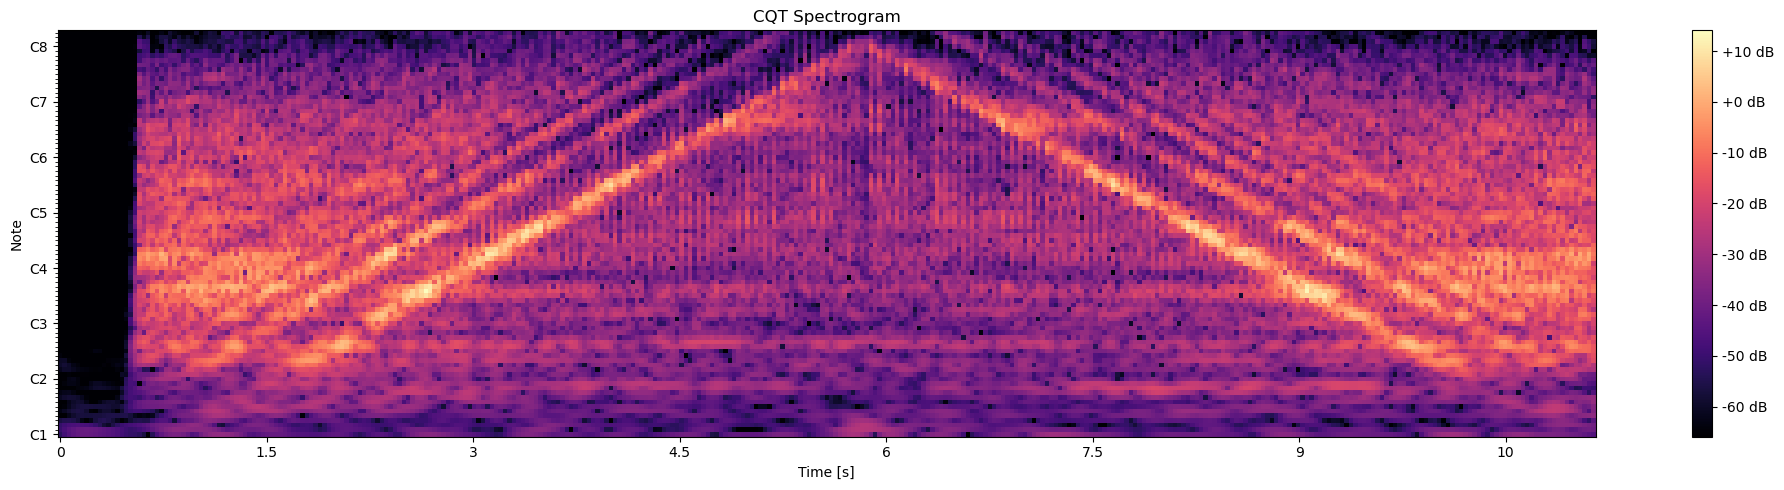

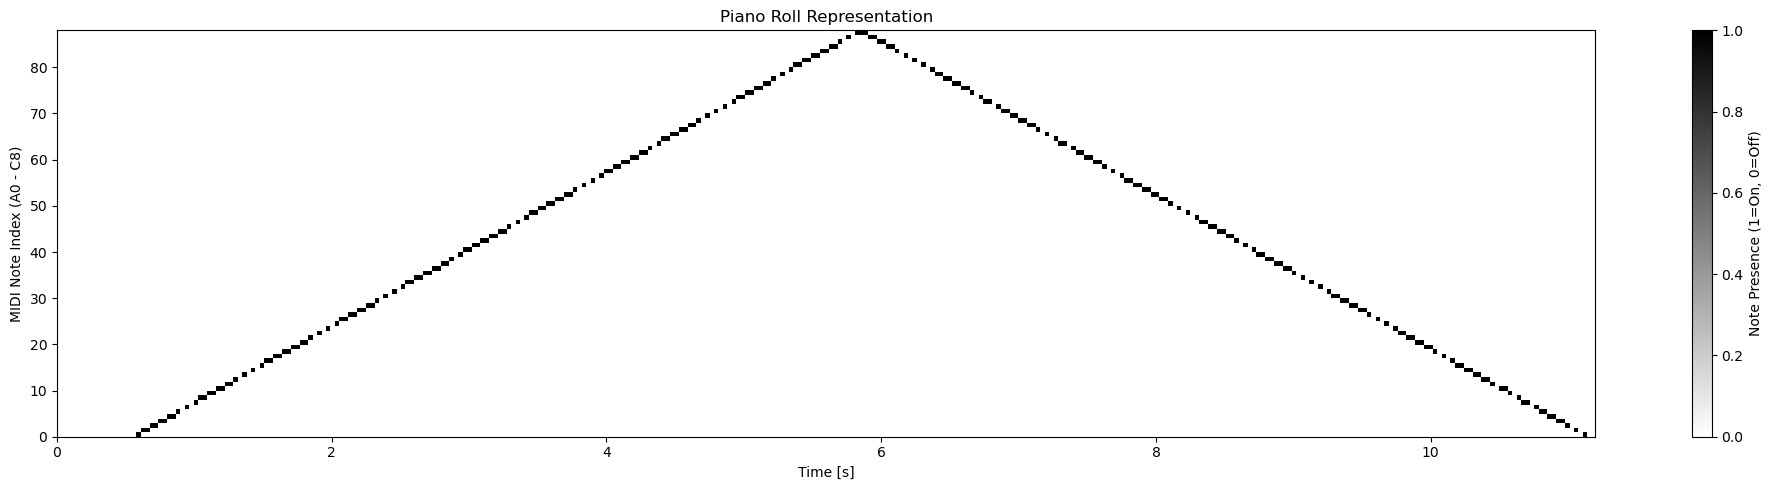

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(88, 349)
(88, 349)
--------------------------
(349, 88)
(349, 88, 7)
(349, 88)


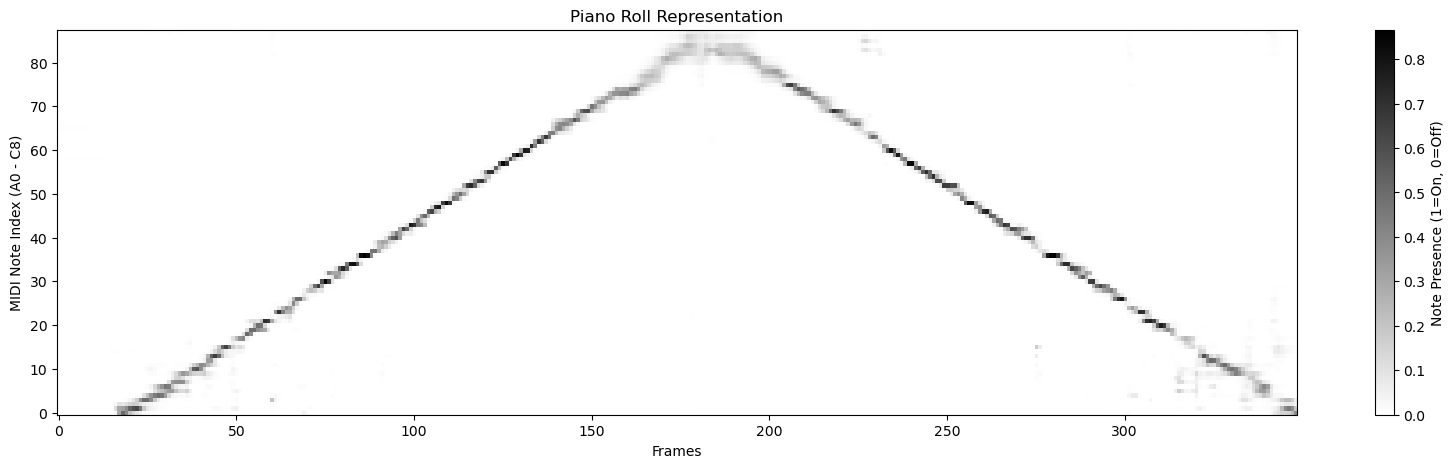

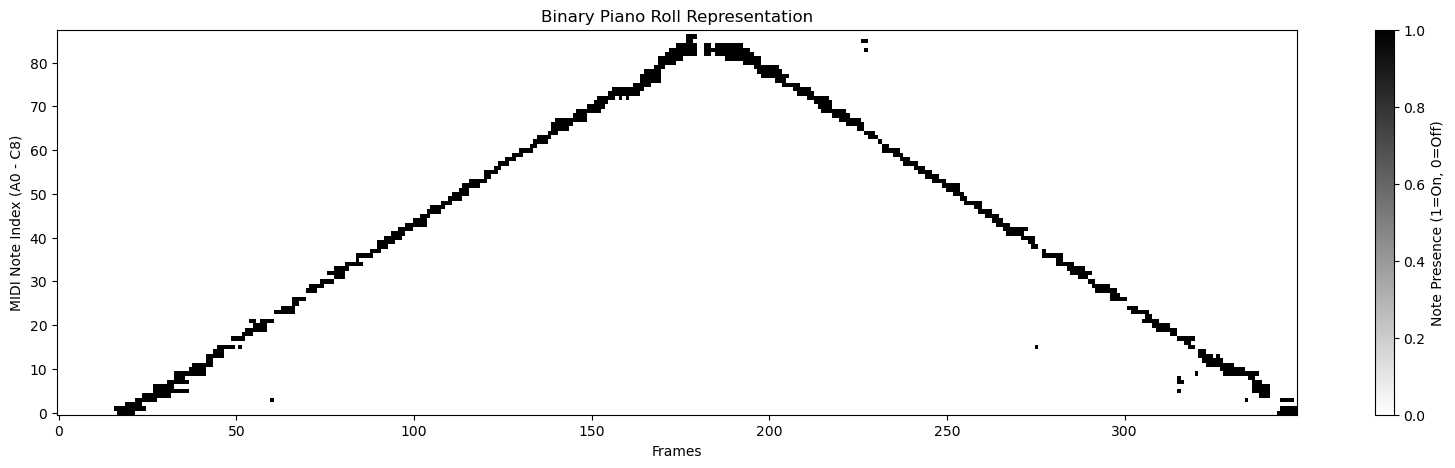

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pretty_midi

from data_preprocessing import get_train_data
from data_preprocessing import group_cqt_frames

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy

# audio = "../databases/combined_database/MAPS_ENSTDkCl/MAPS_ENSTDkCl_2/ENSTDkCl/MUS/MAPS_MUS-scn15_12_ENSTDkCl.wav"
# midi = "../databases/combined_database/MAPS_ENSTDkCl/MAPS_ENSTDkCl_2/ENSTDkCl/MUS/MAPS_MUS-scn15_12_ENSTDkCl.mid"

# audio = "../databases/combined_database/MAPS_ENSTDkCl/MAPS_ENSTDkCl_1/ENSTDkCl/UCHO/I60-68/C0-5-8/MAPS_UCHO_C0-5-8_I60-68_S1_n13_ENSTDkCl.wav"
# midi = "../databases/combined_database/MAPS_ENSTDkCl/MAPS_ENSTDkCl_1/ENSTDkCl/UCHO/I60-68/C0-5-8/MAPS_UCHO_C0-5-8_I60-68_S1_n13_ENSTDkCl.mid"

audio = "../databases/onenote-database/CH/MAPS_ISOL_CH0.05_F_ENSTDkCl.wav"
midi = "../databases/onenote-database/CH/MAPS_ISOL_CH0.05_F_ENSTDkCl.mid"

# audio = "../databases/onenote-database/NO/MAPS_ISOL_NO_F_S1_M77_ENSTDkCl.wav"
# midi = "../databases/onenote-database/NO/MAPS_ISOL_NO_F_S1_M77_ENSTDkCl.mid"

sampling_rate = 16000
hop_length = 512
n_bins = 88
show_cqt_pr = True
pr_in_frames = False
cqt_in_frames = False
num_frames_before = 3
num_frames_after = 3

cqt, labels = get_train_data(audio, sampling_rate, hop_length, n_bins, midi, show_cqt_pr, pr_in_frames, cqt_in_frames)

model = load_model("../saved-models/onenote-saved-models/saved_model_11.h5")
# model = load_model("../saved-models/full-models-from-zero/full_model_from_zero_6.h5")

model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9, learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.F1Score()])

# model.summary()

labels_transposed = np.transpose(labels)
grouped_cqt = group_cqt_frames(cqt, 3, 3)
grouped_cqt_abs = np.abs(grouped_cqt)

predicted_cqt = model.predict(grouped_cqt_abs, batch_size=None,  verbose="auto", steps=None, callbacks=None)

# Define threshold
threshold = 0.1

# Apply threshold to create a binary matrix
binary_matrix = np.where(predicted_cqt > threshold, 1, 0)

print(labels.shape)
print(cqt.shape)
print("--------------------------")
print(labels_transposed.shape)
print(grouped_cqt_abs.shape)
print(predicted_cqt.shape)

# Plot original predicted matrix
plt.figure(figsize=(20, 5))
plt.imshow(predicted_cqt.T, cmap='binary', aspect='auto', origin='lower')
plt.xlabel('Frames')
plt.ylabel('MIDI Note Index (A0 - C8)')
plt.title('Piano Roll Representation')
plt.colorbar(label='Note Presence (1=On, 0=Off)')
# plt.savefig('predicted_piano_roll_mus_th01.png', dpi=750)
plt.show()

# Plot binary matrix
plt.figure(figsize=(20, 5))
plt.imshow(binary_matrix.T, cmap='binary', aspect='auto', origin='lower')
plt.xlabel('Frames')
plt.ylabel('MIDI Note Index (A0 - C8)')
plt.title('Binary Piano Roll Representation')
plt.colorbar(label='Note Presence (1=On, 0=Off)')
# plt.savefig('binary_piano_roll_mus_th01.png', dpi=750)
plt.show()

In [2]:
binary_matrix.shape

(2622, 88)

In [3]:
def binary_matrix_to_midi(binary_matrix, output_midi_file, ticks_per_beat=480, frame_duration_seconds=0.032):
    """
    Convert a binary matrix to a MIDI file.

    Parameters:
    binary_matrix (2D list or numpy array): The binary matrix representing the piano roll.
    output_midi_file (str): The path to save the output MIDI file.
    ticks_per_beat (int): The number of ticks per beat (default 480).
    frame_duration_seconds (float): Duration of each frame in seconds.
    """
    midi = MidiFile(ticks_per_beat=ticks_per_beat)
    track = MidiTrack()
    midi.tracks.append(track)

    # Add a default tempo
    track.append(mido.MetaMessage('set_tempo', tempo=mido.bpm2tempo(120)))

    # Convert frame duration to ticks
    ticks_per_frame = int(frame_duration_seconds * mido.bpm2tempo(120) / 1_000_000 * ticks_per_beat)

    previous_time = 0
    for i, row in enumerate(binary_matrix):
        time_for_this_frame = ticks_per_frame if i == 0 else ticks_per_frame
        for note, value in enumerate(row):
            if value == 1:
                # Note on
                track.append(Message('note_on', note=note, velocity=64, time=time_for_this_frame))
                # Note off (set time to 1 tick after note on)
                track.append(Message('note_off', note=note, velocity=64, time=1))
                time_for_this_frame = 0  # Reset time for subsequent notes in the same frame

    # Save the MIDI file
    midi.save(output_midi_file)
    print(f"MIDI file saved to {output_midi_file}")

# Example usage
import numpy as np

In [122]:
# Example usage:
import numpy as np

# Create a dummy binary matrix (time steps x MIDI notes)
# This is just an example. Replace it with your actual binary matrix.
# binary_matrix = np.zeros((100, 128))
# binary_matrix[10, 60] = 1  # C4 note
# binary_matrix[20, 62] = 1  # D4 note
# binary_matrix[30, 64] = 1  # E4 note

# Convert the binary matrix to a MIDI file
binary_matrix_to_midi(binary_matrix, 'output_trill_onenote_model.mid', 8)

MIDI file saved to output_trill_onenote_model.mid
